In [148]:
import sqlalchemy
engine = sqlalchemy.create_engine('sqlite:///jovyan.db')

In [149]:
inspector = sqlalchemy.inspect(engine)
inspector.get_table_names()

[]

In [150]:
import os
from datetime import datetime as dt

def logfile(user=os.environ.get('JUPYTERHUB_USER') or 'jovyan', 
            date=dt.now().strftime('%Y%m%d'),
            sfx='.log'):
    prefix='/srv'
    if os.path.isdir(prefix) and os.access(prefix, os.W_OK):
        prefix+=('/'+user)
        if not os.path.isdir(prefix):
            os.makedirs(prefix)
    else:
        prefix='.'
    return prefix+'/'+date+sfx

In [151]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime

In [152]:
dt.min

datetime.datetime(1, 1, 1, 0, 0)

In [153]:
import re

pat = re.compile(r'(\d{4})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):(\d{2}).*:summary: \((\d+), (\d+), (\d+)\)')

def activity(user=os.environ.get('JUPYTERHUB_USER') or 'jovyan'):
    try:
        df = pd.read_sql('''select * from nbgrader''',
                        engine, parse_dates=['index'])
        df.set_index('index', drop=True, inplace=True)
        df.index.name = 'time'
        latest_index = df.index.to_pydatetime()[-1]
    except sqlalchemy.exc.SQLAlchemyError:
        latest_index = dt.min
    
    #dt.now().strftime('%Y%m%d')
    for date in ['20220516']:
        try:
            with open(logfile(user, date, '-nbg.log'), 'r') as f:
                for l in f:
                    r = pat.search(l)
                    if r:
                        dy, dm, dd, th, tm, ts, c, p, f = (int(s) for s in r.groups())
                        d = dt.combine(datetime.date(dy, dm, dd),
                                       datetime.time(th, tm, ts))
                        #print(pd.Timestamp(d), c, p, f)
                        if d > latest_index and (int(p)+int(f))> 0:
                            ts_data = np.array((1.,(3*p+f)/(p+f)))
                            df_new = pd.DataFrame([ts_data])
                            df_new.index = [pd.Timestamp(d)]
                            df_new = pd.DataFrame([[1., (3*p+f)/(p+f)]], 
                                                  columns=["y", "pass"],
                                                  index=[pd.Timestamp(d)])
                            df_new.to_sql('nbgrader', engine, if_exists='append')
        except:
            pass
    #return df

In [154]:
activity()

In [155]:
df = pd.read_sql('''select * from nbgrader''',
                    engine, parse_dates=['index'])
df.set_index('index', drop=True, inplace=True)
df.index.name = 'time'
df

,y,pass
time,,
2022-05-16 18:56:30,1.0,3.0
2022-05-16 18:57:07,1.0,3.0
2022-05-16 18:57:47,1.0,3.0
2022-05-16 18:58:39,1.0,3.0
2022-05-16 22:20:03,1.0,1.0
2022-05-16 22:22:10,1.0,3.0


In [138]:
df.iloc[:,1].values

array([3., 3., 3., 3., 1., 3.])

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

def plot_ax(ax, user=os.environ.get('JUPYTERHUB_USER') or 'jovyan'):
    df = pd.read_sql('''select * from nbgrader''',
                     engine, parse_dates=['index'])
    df.set_index('index', drop=True, inplace=True)
    df.index.name = 'time'
    if len(df)>0:
        cmap = plt.cm.Spectral
        ax.scatter(
            x=df.index, y=df['y'].values, 
            c=df['pass'].values, s=df['pass'].values*500,
            cmap='Spectral',
            alpha=0.4, edgecolor='none'
        )
    ax.set_ylabel(user, rotation=0, ha="right", va="center")

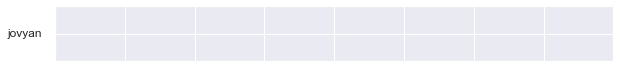

In [117]:
from datetime import date
from datetime import time

fig = plt.figure(figsize=(10,1))
ax = fig.add_subplot(1,1,1)

plt.setp(ax, xlim=(pd.Timestamp(dt.combine(date.today(),time(dt.now().hour-1,))), 
                   pd.Timestamp(dt.combine(date.today(),time(dt.now().hour,59,59)))))
plt.setp(ax, ylim=(0,2))
plt.setp(ax, xticklabels=[])
plt.setp(ax, yticklabels=[])
plot_ax(ax)